# Voting History

## Python setup

In [1]:
# data science imports
import pathlib

import pandas as pd
import numpy as np
import mgplot as mg
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from common import COLOR_COALITION, COLOR_LABOR, RFOOTER

In [2]:
# plotting setup


def set_up_plotting() -> None:
    """Set up plotting."""
    mg.set_chart_dir("../charts/previous-elections/")
    mg.clear_chart_dir()


set_up_plotting()
SHOW = True
LFOOTER = "Australia. Data sourced from the Australian Electoral Commission. "

## Data

In [3]:
def get_data() -> pd.DataFrame:
    """Get the election data."""
    history_url = "../historic-data/election-outcomes.csv"
    table = pd.read_csv(
        history_url,
        header=0,
        index_col=0,
        sep=r"\s+",  # Updated to fix deprecation warning
        comment="#",
        na_values="-",
        parse_dates=["Date"],
    )
    return table


TABLE = get_data()

In [4]:
COALITION = ["LP", "LNP", "NP", "CLP"]
E_OTHERS = ["DLP", "DEM", "GRN", "ON", "UAP", "Others"]
PRIMARY = ["ALP", "LP", "LNP", "NP", "CLP", "DLP", "DEM", "GRN", "ON", "UAP", "Others"]

In [5]:
def check_the_data() -> None:
    """Check the data for consistency."""
    assert TABLE.index.is_monotonic_increasing
    row_sums = TABLE[PRIMARY].sum(axis=1, skipna=True)
    assert (row_sums >= 99.8).all() and (row_sums <= 100.2).all()
    assert (TABLE["ALP"] < TABLE["Labor2pp"]).all()
    assert len(TABLE["GovtBefore"].unique()) == 2
    assert len(TABLE["GovtAfter"].unique()) == 2
    assert (TABLE["Date"].dt.year == TABLE.index).all()


check_the_data()

## Historical plots

### Minor parties

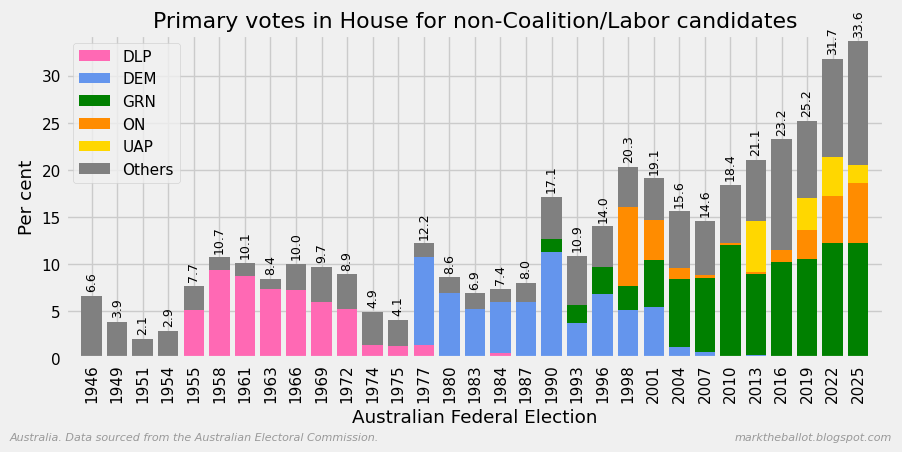

In [6]:
def minor_parties() -> None:
    """Plot the primary votes for minor parties and independents."""

    colors = ("hotpink", "cornflowerblue", "green", "darkorange", "gold", "grey")

    fig, ax = plt.subplots()
    TABLE[E_OTHERS].plot.bar(
        stacked=True,
        ax=ax,
        width=0.8,
        color=list(colors),  # Convert tuple to list for mypy
    )

    # Add total labels above each stacked bar
    for i, (idx, row) in enumerate(TABLE[E_OTHERS].iterrows()):
        total = row.sum()
        ax.text(
            i,
            total + 0.5,
            f"{total:.1f}",
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=9,
            color="black",
        )

    mg.finalise_plot(
        ax,
        title="Primary votes in House for non-Coalition/Labor candidates",
        xlabel="Australian Federal Election",
        ylabel="Per cent",
        lfooter=LFOOTER,
        rfooter=RFOOTER,
        show=SHOW,
    )


minor_parties()

### Mainstream parties

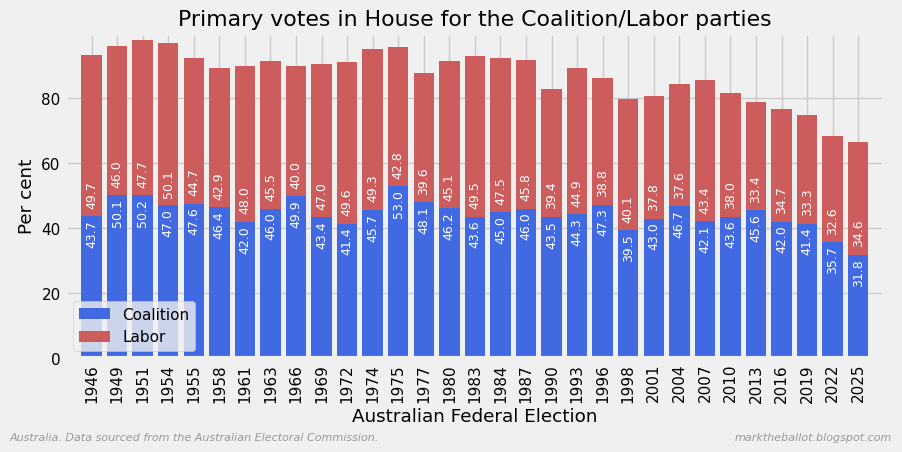

In [7]:
def mainstream_parties() -> None:
    """Plot the primary votes for the two mainstream parties."""

    mainstream = TABLE.copy()
    mainstream["Coalition"] = mainstream[COALITION].sum(axis=1)
    mainstream = mainstream.rename(columns={"ALP": "Labor"})
    majors = ["Coalition", "Labor"]

    fig, ax = plt.subplots()
    mainstream[majors].plot.bar(
        stacked=True, ax=ax, width=0.8, color=[COLOR_COALITION, COLOR_LABOR]
    )

    for i, (lib, lab) in enumerate(
        zip(mainstream["Coalition"].to_list(), mainstream["Labor"].to_list())
    ):
        ax.text(
            i,
            lib - 1,
            f"{lib:.1f}",
            ha="center",
            va="top",
            rotation=90,
            fontsize=9,
            color="white",
        )
        ax.text(
            i,
            lib + 2.5,
            f"{lab:.1f}",
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=9,
            color="white",
        )

    mg.finalise_plot(
        ax,
        title="Primary votes in House for the Coalition/Labor parties",
        xlabel="Australian Federal Election",
        ylabel="Per cent",
        legend={"loc": "lower left"},
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        show=SHOW,
    )


mainstream_parties()

### Election cycles

In [8]:
MARKER_LABOR, MARKER_COALITION = "o", "s"


def add_government(from_table, start, ending, to_cycles, colors, markers):
    name = f"{start}-{ending}"
    selection = from_table.index[
        (from_table.index >= start) & (from_table.index <= ending)
    ]
    dates = from_table.loc[selection].Date
    values = from_table.loc[selection].Labor2pp
    if from_table.at[start, "GovtAfter"] == "Coalition":
        values = 100 - values
        colors[name] = COLOR_COALITION
        markers[name] = MARKER_COALITION
    else:
        colors[name] = COLOR_LABOR
        markers[name] = MARKER_LABOR
    values.index = dates
    to_cycles[name] = values

In [9]:
def change_points() -> tuple[pd.DataFrame, dict[str, str], dict[str, str]]:
    """Identify change points in government."""

    # identify changes of government at an election ...
    changes = TABLE["GovtBefore"] != TABLE["GovtAfter"]
    change_points_array = changes[changes].index.values
    final = TABLE.index[-1]
    if final not in change_points_array:
        change_points_array = np.append(change_points_array, TABLE.index[-1])

    # construct separate runs for each government
    cycles = pd.DataFrame(index=TABLE.Date)
    colors: dict[str, str] = {}  # Add type annotation
    markers: dict[str, str] = {}  # Add type annotation

    start = TABLE.index[0]
    for ending in change_points_array:
        add_government(TABLE, start, ending, cycles, colors, markers)
        start = ending

    # special case - newly elected government
    if TABLE.index[-1] in change_points_array:
        add_government(TABLE, start, TABLE.index[-1], cycles, colors, markers)

    return cycles, colors, markers

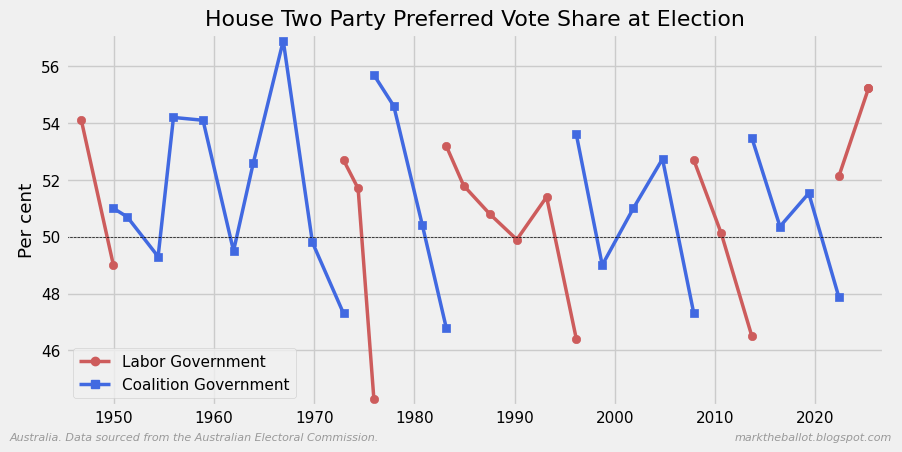

In [10]:
def plot_government_cycles() -> None:
    """Plot the government cycles."""

    # set-up
    cycles, colors, markers = change_points()
    LW = 2.5

    # Plot lines and scatter points
    fig, ax = plt.subplots()
    for column in cycles.columns:
        cycles[column].plot.line(ax=ax, c=colors[column], linewidth=LW)
        ax.scatter(
            cycles.index, cycles[column], marker=markers[column], color=colors[column]
        )

    # custom legend
    custom_lines = [
        Line2D([0], [0], color=COLOR_LABOR, lw=LW, marker=MARKER_LABOR),
        Line2D([0], [0], color=COLOR_COALITION, lw=LW, marker=MARKER_COALITION),
    ]
    ax.legend(custom_lines, ["Labor Government", "Coalition Government"])

    # set x-axis label formatting
    ax.tick_params(axis="x", rotation=0)
    for label in ax.get_xticklabels():
        label.set_horizontalalignment("center")

    # finalise plot with mgplot
    mg.finalise_plot(
        ax,
        xlabel=None,
        ylabel="Per cent",
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        axhline={"y": 50, "color": "black", "linestyle": "--", "linewidth": 0.5},
        title="House Two Party Preferred Vote Share at Election",
        show=SHOW,
    )


plot_government_cycles()

### Preference flows

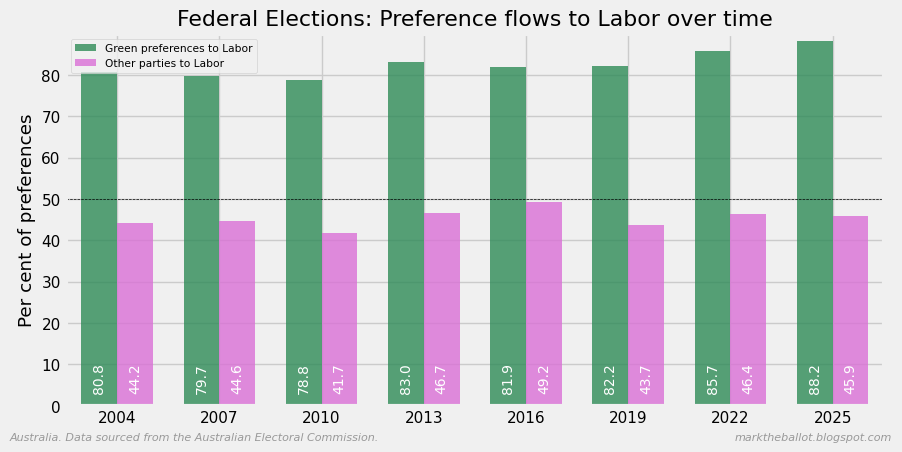

In [11]:
def pref_flows() -> None:
    """Preference flows at recent elections."""

    directory_path = pathlib.Path("../historic-data/preferences")

    # Check if directory exists
    if not directory_path.exists():
        print(f"Warning: Preferences directory not found: {directory_path}")
        print("Skipping preference flows analysis.")
        return

    # Only process the main preference flow files (not state-by-state files)
    files = list(directory_path.glob("*two-party-preferred-flow-by-party.csv"))

    # Check if any CSV files found
    if not files:
        print(f"Warning: No preference flow CSV files found in {directory_path}")
        print("Skipping preference flows analysis.")
        return

    results = []
    for file in sorted(files):
        try:
            year = file.stem.split("-")[0]
            frame = pd.read_csv(
                file,
                comment="#",
                sep=",",
                header=0,
                index_col=0,
                na_values="-",
            )
            frame = frame.dropna(how="all", axis=1)
            frame = frame.dropna(how="all", axis=0)
            frame = frame[frame.index.notna()]

            # Handle different column name patterns across elections
            # Find the Labor and Coalition transfer vote columns
            labor_votes_col = None
            coalition_votes_col = None

            for col in frame.columns:
                if "Australian Labor Party Transfer Votes" in col:
                    labor_votes_col = col
                elif "Liberal/National Coalition Transfer Votes" in col:
                    coalition_votes_col = col

            if not labor_votes_col or not coalition_votes_col:
                print(f"Warning: Could not find required columns in {file.name}")
                print(f"Available columns: {frame.columns.tolist()}")
                continue

            # Calculate row sums for transfers
            row_sums = frame[coalition_votes_col] + frame[labor_votes_col]

            # Get Green preference flow to Labor (handle if GRN doesn't exist)
            if "GRN" in frame.index:
                green = frame.loc["GRN", labor_votes_col] / row_sums["GRN"]
            else:
                print(f"Warning: No GRN data found in {year}")
                green = 0.0

            # Remove major parties and calculate other parties flow
            frame = frame.drop(labels=["GRN", "LP", "NP"], errors="ignore")
            other = frame[labor_votes_col].sum() / (
                frame[labor_votes_col].sum() + frame[coalition_votes_col].sum()
            )

            series = pd.Series([green, other], index=["Green", "Other"])
            series.name = year
            results.append(series)

        except Exception as e:
            print(f"Warning: Error processing file {file.name}: {e}")
            continue

    # Check if we have any results to plot
    if not results:
        print("Warning: No valid preference data found. Skipping chart creation.")
        return

    df = pd.concat(results, axis=1).T * 100
    df = df.sort_index()  # Sort by year

    # Use matplotlib bar plot with mgplot finalizing
    fig, ax = plt.subplots(figsize=(12, 8))

    # Create grouped bar chart
    width = 0.35
    x = range(len(df.index))

    bars1 = ax.bar(
        [i - width / 2 for i in x],
        df["Green"],
        width,
        label="Green preferences to Labor",
        color="seagreen",
        alpha=0.8,
    )
    bars2 = ax.bar(
        [i + width / 2 for i in x],
        df["Other"],
        width,
        label="Other parties to Labor",
        color="orchid",
        alpha=0.8,
    )

    # Add value labels on bars with rotation=90
    placement = 3
    for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
        # Green bar labels
        height1 = bar1.get_height()
        ax.text(
            bar1.get_x() + bar1.get_width() / 2.0,
            placement,
            f"{height1:.1f}",
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=10,
            color="white",
        )

        # Other bar labels
        height2 = bar2.get_height()
        ax.text(
            bar2.get_x() + bar2.get_width() / 2.0,
            placement,
            f"{height2:.1f}",
            ha="center",
            va="bottom",
            rotation=90,
            fontsize=10,
            color="white",
        )

    # Set x-axis labels
    ax.set_xticks(x)
    ax.set_xticklabels(df.index, rotation=0)

    mg.finalise_plot(
        ax,
        title="Federal Elections: Preference flows to Labor over time",
        ylabel="Per cent of preferences",
        xlabel=None,
        rfooter=RFOOTER,
        lfooter=LFOOTER,
        axhline={"y": 50, "color": "black", "linestyle": "--", "linewidth": 0.5},
        legend=True,
        show=SHOW,
    )


pref_flows()

## The End

In [12]:
%load_ext watermark
%watermark --python --machine --conda --iversion --watermark

Python implementation: CPython
Python version       : 3.13.5
IPython version      : 9.4.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 24.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

pathlib   : 1.0.1
numpy     : 2.3.1
matplotlib: 3.10.3
mgplot    : 0.2.11
pandas    : 2.3.1

Watermark: 2.5.0



In [13]:
print("It is done")

It is done
